In [50]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Dense, Embedding, Flatten, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


NUM = 20000
max_twit_len = 27


* NUM - количество слов в словаре
* max_twit_len - число слов в одном твитте

Изначально параметрами были 100000 и 20 соответственно, значения были выбраны эмпирически, а затем изменены исходя из результатов исследования


Выше находятся не все библиотеки, использованные для решения задания. Вынесены они сюда для удобства, так как используются довольно часто. Ну и вообще, лишние импорты затудняют читабельность кода

# Загрузка данных

In [51]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2020-07-08 08:37:34--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2020-07-08 08:37:34--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc60e43fa13b84d6b78460b13e93.dl.dropboxusercontent.com/cd/0/inline/A7FFOkr0TICtXzJN8UxwQa2wOQBhKQj2jJl_R0PcxdWkQ8U3CL5AKiRfOwM85ti9soLCAOwcdM2ZCmW809TWLPBhA9WTHs1Ww4rojH7yWgqyjg/file# [following]
--2020-07-08 08:37:34--  https://uc60e43fa13b84d6b78460b13e93.dl.dropboxusercontent.com/cd/0/inline/A7FFOkr0TICtXzJN8UxwQa2wOQBhKQj2jJl_R0PcxdWkQ8U3CL5AKiRfOwM85ti9soLCAOwcdM2ZCmW809TWLPBhA9WTHs1Ww4rojH7yWgqyjg/file
Resolving uc60e43fa

In [52]:
names = ['id', 'date','name','text','type','trep','trtw','tfav', 'tstcount','tfol','tfrien','listcount'] # названия колонок

positive = pd.read_csv('positive.csv', sep=";", header=None, names=names)
negative = pd.read_csv('negative.csv', sep=";", header=None, names=names)

negative.type=0 #приравниваем к нулю, потому что в исходных данных и у positive и у negative type=1
df = pd.concat((positive,negative), ignore_index=True) # объединяем позитивные и негативные тивитты в один датафрейм
df=df.sample(frac=1) # перемешиваем данные

Возможно данные можно было и не перемешивать, но когда в датасете подряд идет сначала только один класс, а потом только другой - это скорее всего плохо

# Изучение данных

In [10]:
df.head(10)

,id,date,name,text,type,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
102252,411100723578146816,1386849025,SmokyParadise,RT @dinochkameow: @SmokyParadise девушки старш...,1,0,1,0,13596,260,123,0
212042,422783947404509184,1389634522,the_endless_voi,RT @_just_muggle: @the_endless_voi азахах а я ...,0,0,1,0,2795,162,126,2
144282,412744024928579584,1387240818,maaaagic,"Лежу вся такая ништячковая, летнаяя, на газонч...",0,0,0,0,1789,74,66,4
170967,415828580728578048,1387976234,catforever5,В понедельник сломалась зарядка.-. Только в че...,0,0,0,0,26,3,6,0
29717,409630214302343168,1386498428,StandByYou_SuG,@Melanie_Bunny на даче ахах) он будет пропалыв...,1,0,0,0,609,26,53,0
9911,409207483777818624,1386397641,margo_lemeshko,"Вот,что это такое?Сидишь,никого не трогаешь и ...",1,0,0,0,35,10,13,0
191341,419100579659407360,1388756339,_Komarova_Daria,Этикет. Обувь ВСЕГДА должна быть чистой.\n Про...,0,0,0,0,3127,47,41,0
6885,409090070692392960,1386369648,modno_molodezno,"порой мне кажется, что я недостойна такого иде...",1,0,0,0,1895,71,59,0
208559,422369510583439360,1389535713,JulkinsS,У меня от физики уже пухнет голова:( И это тол...,0,0,0,0,1360,11,27,0
28560,409616107679789056,1386495065,Drozdovskynext,"@EwVOLOBUEV @azmbog @pillSa Ага, и потом корми...",1,0,0,0,8304,1252,499,26


In [ ]:
positive.shape

(114911, 12)

На сайте с датасетом написано, что должен быть 114991 экземпляр позитивного класса, возмоно как-то не так считалось, хотя скоее всего опечатка

In [ ]:
negative.shape

(111923, 12)

Пояснение к названиям колонок:

* id: уникальный номер сообщения в системе twtter;
* date: дата публикации твита;
* name: имя пользователя, опубликовавшего сообщение;
* text:  текст твита;
* type: принадлежность к классу;
* trtw: количество ретвитов
* trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
* tfav: количество добавлений в избранное твита другими пользователями;
* tstcount: число всех сообщений пользователя в сети twitter;
* tfol: количество подписчиков
* tfrien: количество подписок
* listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

Не все из колонок нужны для решения задач

* id пользователя явно не даст никакой полезной информации
* Скорее всего дата публикации твитта не должна влиять на его эмоциональный  окрас или же количество ретвиттов


In [17]:
df=df.drop(['id','date'], axis=1)

In [12]:
df.head()

,name,text,type,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
102252,SmokyParadise,RT @dinochkameow: @SmokyParadise девушки старш...,1,0,1,0,13596,260,123,0
212042,the_endless_voi,RT @_just_muggle: @the_endless_voi азахах а я ...,0,0,1,0,2795,162,126,2
144282,maaaagic,"Лежу вся такая ништячковая, летнаяя, на газонч...",0,0,0,0,1789,74,66,4
170967,catforever5,В понедельник сломалась зарядка.-. Только в че...,0,0,0,0,26,3,6,0
29717,StandByYou_SuG,@Melanie_Bunny на даче ахах) он будет пропалыв...,1,0,0,0,609,26,53,0


В таком формате вывода не виден полный текст твиттов, выведем его отдельно

In [ ]:
# позитивные твитты
for i in range(10):
  print(df.text[i])
# негативные твитты
for i in range(114911,114911+10):
  print(df.text[i])

@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)
Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D
RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!
RT @digger2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" :DD http://t.co/GqG6iuE2…
@irina_dyshkant Вот что значит страшилка :D
Но блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D
ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6
RT @SpoonLamer: Ох,900 :D ну это конечно же @twinkleAYO . Чтобы у нее было много друзей, ведь она такая мимими &lt;3
RT @veregijytaqo: У тебя есть ухажёр? Нет - мои уши не кто не жрёт :D
Поприветствуем моего нового читателя @Alexey1789 ;)
Теперь у меня есть частичка Сиднея :) #Sydney #SydneyOperaHouse http://t.co/agnto3CZEi
на работе был полный пиддес :| и так каждое закрытие месяца, я же свихнусь так D:
Коллеги сидят рубятся в Urban te

Можно обратить внимание на то, что в тексте часто встречаются ссылки, упоминания других пользователей, а также различные символы, обозначающие смайлики.

Это лишняя информация, которая мешает обучению, поэтому ее нужно будет убрать.

Также некоторые слова написаны с ошибками, поэтому возможно имеет смысл их исправить.

In [13]:
df.describe()

,type,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
count,226834.000000,226834.0,226834.000000,226834.000000,2.268340e+05,2.268340e+05,226834.000000,226834.000000
mean,0.506586,0.0,3.118249,0.001243,7.584972e+03,6.770083e+02,332.682746,10.125475
std,0.499958,0.0,105.898784,0.035611,2.039972e+04,9.764450e+03,1915.268263,112.100088
min,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,4.730000e+02,2.700000e+01,29.000000,0.000000
50%,1.000000,0.0,0.000000,0.000000,2.026000e+03,8.300000e+01,72.000000,0.000000
75%,1.000000,0.0,0.000000,0.000000,7.562000e+03,2.570000e+02,197.000000,2.000000
max,1.000000,0.0,13817.000000,2.000000,1.138639e+06,1.582807e+06,388311.000000,16915.000000


Интересно, что минимум 75% твиттов вообще не имеют ретвиттов. При неправильной метрике можно было бы прогнозировать всем твиттам 0 ретвиттов и при этом иметь хорошую точность предсказаний.

Еще стоит обратить внимание на tfav(количество добавлений в избранное твитта другими пользователями), максимальное значение 2 это довольно странно. Есть подозение, что что-то тут не чисто. Плюс ко всему для регрессии этот столбец все-равно использовать нельзя (информация из "будущего"), а для классификатора он в принципе и не нужен, так что этот столбец следует удалить.

Так же стоит обратить внимание на то, что trep полностью состоит из нулей и его точно следует удалить

Теперь оценим распределение длинн слов в твиттах

P.S. Удобнее всего это делать после предобработки, на этапе когда слова уже заменены токенами, поэтому если необходимо запустить эти блоки, то с начала надо запустить блоки из следующего раздела

In [ ]:
twitts=pd.DataFrame([])
twitts["token"] = sequences
twitts["count"] = twitts.apply(lambda x: len(x['token']), axis=1)
twitts.head()

,token,count
0,"[23, 3100, 23, 665, 3143, 783, 133, 10]",8
1,"[7, 1, 2066, 37, 237, 66840]",6
2,"[7, 1, 69, 66, 497, 11170, 2279, 4, 142, 1784,...",13
3,"[7, 1, 66841, 18378, 11, 66842, 1254, 339, 11,...",10
4,"[2589, 2, 44517, 25, 352, 18, 12, 265, 16603, ...",12


In [ ]:
twitts["count"].describe()

count    181468.000000
mean         12.055784
std           4.938806
min           0.000000
25%           8.000000
50%          11.000000
75%          15.000000
max          40.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'Распределение количества слов в твиттах')

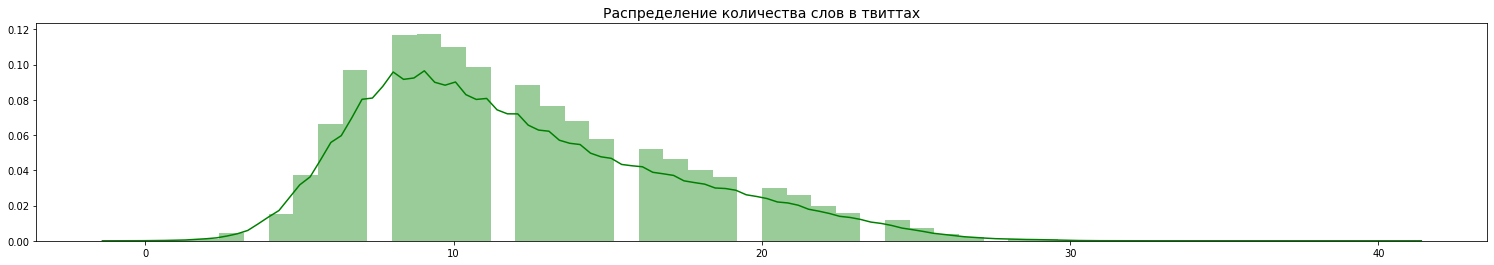

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(26,4))
val = twitts["count"].values

sns.distplot(val , ax=ax, color='g')
ax.set_title('Распределение количества слов в твиттах', fontsize=14)

Как видно из графика, большая часть длинны твиттов меньше, чем в 25-28 слов. При приведения твиттов к одной длинне скорее всего лучшая точность классификации будет достигаться при выборе значения на отрезке 20-30 слов, хотя возможно хорошее качество будет ближе к среднему значению по длиннам твиттов, то есть 10-15 слов. Это еще нужно проверить

# Обработка данных

Что изменяем:
* Приведение к нижнему регистру и замена 'ё' на 'е' чтобы не дублировать одинаковые слова в словаре
* Все ссылки заменяем на 'URL' потому что для модели не важно куда ведет ссылка, но может быть важно наличие в этом месте ссылки, чтобы контекст был полным
* Удаляем все символы кроме букв и цифр
* Удаляем лишние пробелы
* Лемматизация для того, чтобы разные формы слова не считались за разные слова


In [53]:
!pip install pymorphy2
import pymorphy2
import re

ma = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    #text = re.sub('(хах?[^\s]+)', 'хах', text) 
    text = " ".join(ma.parse(word)[0].normal_form for word in text.split())#лемматизация
    return text.strip()

df["preprocess_text"] = [preprocess_text(t) for t in df.text]

Далее нормализуем числовые данные которые будут входными для нейронной сети. Это стоит сделать, потому что некоторые значения имеют 6 степень, это слишком много.

In [54]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler() # RobustScaler менее подвержен выбросам
std_scaler = StandardScaler()
			
df['scaled_tstcount'] = rob_scaler.fit_transform(df['tstcount'].values.reshape(-1,1))
df['scaled_tfol'] = rob_scaler.fit_transform(df['tfol'].values.reshape(-1,1))
df['scaled_tfrien'] = rob_scaler.fit_transform(df['tfrien'].values.reshape(-1,1))
df['scaled_listcount'] = rob_scaler.fit_transform(df['listcount'].values.reshape(-1,1))

In [19]:
df.describe()

,type,trep,trtw,tfav,tstcount,tfol,tfrien,listcount,scaled_tstcount,scaled_tfol,scaled_tfrien,scaled_listcount
count,226834.000000,226834.0,226834.000000,226834.000000,2.268340e+05,2.268340e+05,226834.000000,226834.000000,226834.000000,226834.000000,226834.000000,226834.000000
mean,0.506586,0.0,3.118249,0.001243,7.584972e+03,6.770083e+02,332.682746,10.125475,0.784169,2.582645,1.551683,5.062738
std,0.499958,0.0,105.898784,0.035611,2.039972e+04,9.764450e+03,1915.268263,112.100088,2.877658,42.454130,11.400406,56.050044
min,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.285795,-0.360870,-0.428571,0.000000
25%,0.000000,0.0,0.000000,0.000000,4.730000e+02,2.700000e+01,29.000000,0.000000,-0.219072,-0.243478,-0.255952,0.000000
50%,1.000000,0.0,0.000000,0.000000,2.026000e+03,8.300000e+01,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,0.000000,0.000000,7.562000e+03,2.570000e+02,197.000000,2.000000,0.780928,0.756522,0.744048,1.000000
max,1.000000,0.0,13817.000000,2.000000,1.138639e+06,1.582807e+06,388311.000000,16915.000000,160.334744,6881.408696,2310.946429,8457.500000


Как видно, максимальные значения уменьшились на 2 порядка, а седние значения уменьшились в 4 раза. С такими данными сети будет проще работать.

А теперь удалим старые значения этих столбцов.

In [55]:
df.drop(['tstcount','tfol','tfrien','listcount'], axis=1, inplace=True)

Далее нужно разделить данные на обучающую и тестовую выборку. Используем StratifiedKFold так как он соохраняет балланс классов

In [56]:
x = df.drop(['type','id','date','name','trtw','trep','tfav','text'], axis=1)
y = df['type']

# возвращает train и test сохраняя при этом баланс классов
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# skf.split генерирует индексы
for train_index, test_index in skf.split(x, y):
    data_train, data_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rtw_train, rtw_test = df['trtw'].iloc[train_index], df['trtw'].iloc[test_index]


# Преобразуем в массив
text_train = data_train['preprocess_text'].values
text_test = data_test['preprocess_text'].values
data_train=data_train.drop('preprocess_text', axis=1).values
data_test=data_test.drop('preprocess_text', axis=1).values
rtw_train=rtw_train.values
rtw_test=rtw_test.values
y_train = y_train.values
y_test = y_test.values

# Убедимся в том, что балланс классов не изменился
a,b=np.unique(y_train, return_counts=True)
c,d=np.unique(y_test, return_counts=True)
print('Label Distributions: \n')
print(b/ len(y_train))
print(d/ len(y_test))

Label Distributions: 

[0.49341482 0.50658518]
[0.49340916 0.50659084]


Далее обучим токенизатор и преобразуем текстовые данные в обучающем и тестовом датасете, в числовые значения

In [57]:
# объявим токенизатор
tokenizer = Tokenizer(num_words=NUM)
# обучим токенизатор
tokenizer.fit_on_texts(text_train)
# токенизируем текст
sequences = tokenizer.texts_to_sequences(text_train)
# ограничим длинну отзывов
x_train = pad_sequences(sequences, maxlen=max_twit_len)

test_sequences = tokenizer.texts_to_sequences(text_test)
x_test = pad_sequences(test_sequences, maxlen=max_twit_len)


Посмотрим на словарь слов

In [24]:
tokenizer.word_index

{'user': 1,
 'я': 2,
 'не': 3,
 'и': 4,
 'в': 5,
 'на': 6,
 'rt': 7,
 'что': 8,
 'а': 9,
 'с': 10,
 'url': 11,
 'весь': 12,
 'ты': 13,
 'быть': 14,
 'это': 15,
 'как': 16,
 'у': 17,
 'то': 18,
 'так': 19,
 'd': 20,
 'но': 21,
 'он': 22,
 'ну': 23,
 'мы': 24,
 'по': 25,
 'мой': 26,
 'за': 27,
 'хотеть': 28,
 'такой': 29,
 'ещё': 30,
 'уже': 31,
 'вот': 32,
 'день': 33,
 'да': 34,
 'же': 35,
 'только': 36,
 'о': 37,
 'она': 38,
 'мочь': 39,
 'один': 40,
 'сегодня': 41,
 'бы': 42,
 'нет': 43,
 'к': 44,
 'вы': 45,
 'когда': 46,
 'они': 47,
 'кто': 48,
 'очень': 49,
 'этот': 50,
 'из': 51,
 'год': 52,
 'просто': 53,
 'хороший': 54,
 '3': 55,
 'какой': 56,
 'тот': 57,
 'человек': 58,
 'от': 59,
 'знать': 60,
 'свой': 61,
 'теперь': 62,
 'если': 63,
 '2': 64,
 'любить': 65,
 'надо': 66,
 'есть': 67,
 'тоже': 68,
 'даже': 69,
 'завтра': 70,
 'там': 71,
 'до': 72,
 'самый': 73,
 'вообще': 74,
 'себя': 75,
 'делать': 76,
 '1': 77,
 'для': 78,
 'большой': 79,
 'спасибо': 80,
 'сейчас': 81,
 'сказ

Посмотрим на данные для обучения

In [ ]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   23, 3100,   23,  665, 3143,  783,  133,   10], dtype=int32)

# Embedding без предварительного обучения + LSTM для классификации

Первым делом попробуем решить задачу при помощи рекуррентной нейронной сети LSTM, без обучения языковой модели, просто обучая Embedding.
Основной причиной почему именно LSTM заключается в том, что у этой архитектуры получается учитывать контекст, при этом не страдая от проблемы долгосрочных зависимостеей. Возможно здесь подошла бы более простая модель GRU, но какой-то огромной разницы между ними нет.

В качестве регуляризации будем использовать пространственный дропаут после embedding для того, чтобы выключались не отдельные значения векторов слов, а вектора слов целиком. Таким образом получится в отдельном твитте на некоторых итерациях избежать влияния отдельных слов на конечный результат, что способствует более тонкой настройке весов менее важных слов, которые без выключения более важных не смогли бы нормально обучиться

После LSTM уже используем обычный dropout

По каким-то странным обстоятельствам в керас не было макро f1 меры. Поэтому пишлось компилировать с precisiom и recall, а потом через них на графике выводить формулу f1 меры. Для оценки работы модели на тестовом множестве уже используется макро f1 мера из sklearn

In [9]:
from tensorflow.keras.layers import SpatialDropout1D
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     

Epoch 1/3
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1276/1276 [==============================] - 144s 113ms/step - loss: 0.5020 - precision: 0.7556 - recall: 0.7393 - val_loss: 0.4679 - val_precision: 0.7573 - val_recall: 0.8063
Epoch 2/3
1276/1276 [==============================] - 144s 112ms/step - loss: 0.4229 - precision: 0.8095 - recall: 0.7971 - val_loss: 0.4611 - val_precision: 0.7952 - val_recall: 0.7487
Epoch 3/3
1276/1276 [==============================] - 148s 116ms/step - loss: 0.3836 - precision: 0.8311 - recall: 0.8190 - val_loss: 0.4797 - val_precision: 0.8083 - val_recall: 0.7265


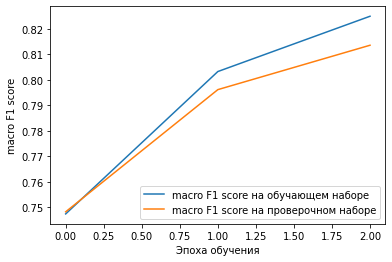

In [10]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='macro F1 score на обучающем наборе')
plt.plot(f1_val, label='macro F1 score на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('macro F1 score')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7784566271482934

В принципе, 3 эпох хватило, но можно проверить начнется ли после 3 переобучение

In [15]:
from tensorflow.keras.layers import SpatialDropout1D
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)     

Epoch 1/4
1276/1276 [==============================] - 154s 121ms/step - loss: 0.5017 - precision: 0.7500 - recall: 0.7464 - val_loss: 0.4724 - val_precision: 0.7934 - val_recall: 0.7219
Epoch 2/4
1276/1276 [==============================] - 146s 114ms/step - loss: 0.4246 - precision: 0.8080 - recall: 0.7936 - val_loss: 0.4667 - val_precision: 0.8030 - val_recall: 0.7316
Epoch 3/4
1276/1276 [==============================] - 142s 111ms/step - loss: 0.3856 - precision: 0.8312 - recall: 0.8163 - val_loss: 0.4634 - val_precision: 0.7740 - val_recall: 0.7940
Epoch 4/4
1276/1276 [==============================] - 146s 115ms/step - loss: 0.3532 - precision: 0.8476 - recall: 0.8339 - val_loss: 0.4824 - val_precision: 0.7957 - val_recall: 0.7511


Макро F1 мера слегка ухудшилась, так что скорее всего дальнейшее обучение не имеет смысла

In [16]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7784078923738446

Dropout не всегда помогает, поэтому попробуем его убрать и посмотреть как изменится метика качества

In [18]:
from tensorflow.keras.layers import SpatialDropout1D
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     

Epoch 1/3
1276/1276 [==============================] - 144s 113ms/step - loss: 0.5003 - precision: 0.7512 - recall: 0.7491 - val_loss: 0.4682 - val_precision: 0.7924 - val_recall: 0.7314
Epoch 2/3
1276/1276 [==============================] - 142s 111ms/step - loss: 0.4208 - precision: 0.8095 - recall: 0.7966 - val_loss: 0.4662 - val_precision: 0.7527 - val_recall: 0.8250
Epoch 3/3
1276/1276 [==============================] - 142s 111ms/step - loss: 0.3823 - precision: 0.8305 - recall: 0.8193 - val_loss: 0.4652 - val_precision: 0.7865 - val_recall: 0.7796


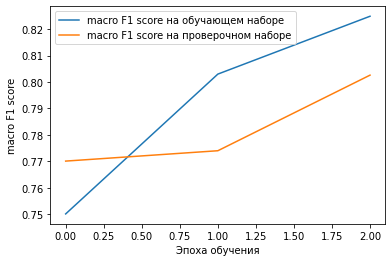

In [19]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='macro F1 score на обучающем наборе')
plt.plot(f1_val, label='macro F1 score на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('macro F1 score')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7802418079294157

Метика улучшилась, видимо втоой dropout был лишним

# Embedding без предварительного обучения + одномерная CNN

Сверточные нейронные сети тоже могут учитывать контекст, но не так сильно, в 

In [23]:
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(Conv1D(350, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/4
1276/1276 [==============================] - 81s 63ms/step - loss: 0.4864 - precision: 0.7604 - recall: 0.7536 - val_loss: 0.4513 - val_precision: 0.7898 - val_recall: 0.7701
Epoch 2/4
1276/1276 [==============================] - 82s 64ms/step - loss: 0.3632 - precision: 0.8418 - recall: 0.8333 - val_loss: 0.4570 - val_precision: 0.7943 - val_recall: 0.7835
Epoch 3/4
1276/1276 [==============================] - 84s 66ms/step - loss: 0.2443 - precision: 0.9043 - recall: 0.8945 - val_loss: 0.5462 - val_precision: 0.7824 - val_recall: 0.7742
Epoch 4/4
1276/1276 [==============================] - 84s 66ms/step - loss: 0.1459 - precision: 0.9460 - recall: 0.9392 - val_loss: 0.6581 - val_precision: 0.7544 - val_recall: 0.8113


val loss после 2 эпохи начинает расти соответсвенно модель переобучается

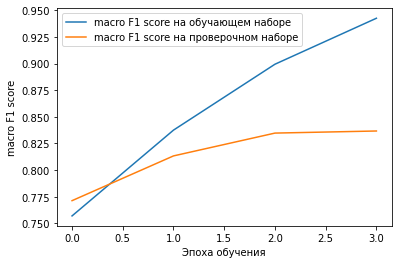

In [24]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='macro F1 score на обучающем наборе')
plt.plot(f1_val, label='macro F1 score на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('macro F1 score')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7700721239345203

In [29]:
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(Conv1D(350, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=2,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/2
1276/1276 [==============================] - 81s 64ms/step - loss: 0.4850 - precision: 0.7618 - recall: 0.7567 - val_loss: 0.4538 - val_precision: 0.7591 - val_recall: 0.8189
Epoch 2/2
1276/1276 [==============================] - 81s 64ms/step - loss: 0.3594 - precision: 0.8460 - recall: 0.8357 - val_loss: 0.4585 - val_precision: 0.7569 - val_recall: 0.8373


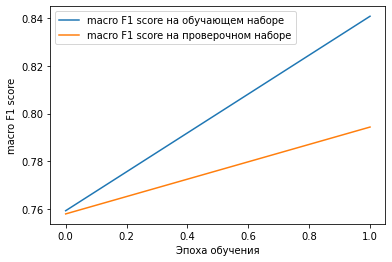

In [30]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='macro F1 score на обучающем наборе')
plt.plot(f1_val, label='macro F1 score на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('macro F1 score')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7851555699785268

Получилось достигнуть неплохого резуьтата, тепеь попробуем увеличить размер окна свертки

In [32]:
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(Conv1D(350, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=2,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/2
1276/1276 [==============================] - 101s 79ms/step - loss: 0.4848 - precision: 0.7588 - recall: 0.7615 - val_loss: 0.4509 - val_precision: 0.7928 - val_recall: 0.7633
Epoch 2/2
1276/1276 [==============================] - 95s 75ms/step - loss: 0.3550 - precision: 0.8472 - recall: 0.8378 - val_loss: 0.4510 - val_precision: 0.7953 - val_recall: 0.7584


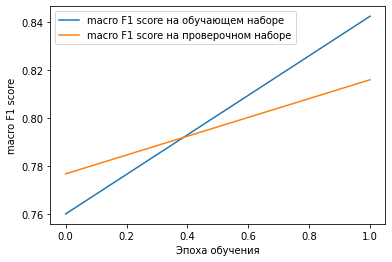

In [33]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='macro F1 score на обучающем наборе')
plt.plot(f1_val, label='macro F1 score на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('macro F1 score')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7828948244083297

Тоже неплохой результат, но немного хуже

# w2v

Теперь попробуем обучить языковую модель. 

Для справки, я этого раньше не делал, поэтому скорее всего что-то делаю не так, результат не очень вышел.

In [148]:
with open('tweets.txt', 'w', encoding='utf-8') as f:
  for tweet in df['preprocess_text']:
     print(tweet, file=f)

In [149]:
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Считываем файл с предобработанными твитами
data = gensim.models.word2vec.LineSentence('tweets.txt')
# Обучаем модель 
model = Word2Vec(data, size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())
model.save("model.w2v")

2020-07-07 09:31:20,114 : INFO : collecting all words and their counts
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-07-07 09:31:20,119 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-07 09:31:20,201 : INFO : PROGRESS: at sentence #10000, processed 123179 words, keeping 15941 word types
2020-07-07 09:31:20,281 : INFO : PROGRESS: at sentence #20000, processed 246984 words, keeping 24618 word types
2020-07-07 09:31:20,365 : INFO : PROGRESS: at sentence #30000, processed 370959 words, keeping 31562 word types
2020-07-07 09:31:20,447 : INFO : PROGRESS: at sentence #40000, processed 495671 words, keeping 37584 word types
2020-07-07 09:31:20,525 : IN

In [151]:
nb_words = min(NUM, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, 200))

i=0
for word in tokenizer.word_index:
    if i >= nb_words:
        continue
    embedding_vector=model[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
       words_not_found.append(word)
    i=i+1
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


number of null word embeddings: 0


In [152]:
embedding_matrix[0]

array([-4.12300557e-01, -4.90435004e-01, -7.05985010e-01, -7.44246244e-01,
       -1.20101130e+00,  2.81018138e-01, -4.62098479e-01,  6.29700541e-01,
        1.22672744e-01,  5.40628545e-02, -5.77204466e-01, -1.36475563e+00,
        5.41002452e-01, -3.44653606e-01, -5.82835317e-01,  2.81862356e-02,
       -8.48452270e-01,  2.31452193e-02, -3.93359095e-01, -8.15561354e-01,
        1.05555028e-01,  1.70883182e-02, -9.65945661e-01, -7.26729512e-01,
        1.92864180e-01,  2.55960286e-01, -3.48819882e-01,  5.05519450e-01,
       -3.77087653e-01,  1.57797098e-01,  3.51348460e-01,  1.18803009e-01,
        1.02586031e+00,  3.17667395e-01,  7.19393492e-01, -8.59722570e-02,
       -6.46227360e-01,  6.40235543e-01, -3.40976298e-01, -7.06190348e-01,
       -1.81207061e-01,  7.48245239e-01, -9.12794620e-02, -6.81485653e-01,
       -1.03150845e+00,  2.64549583e-01, -8.43726322e-02,  6.15109317e-02,
       -1.49453551e-01,  2.54418969e-01, -4.84452665e-01,  7.24340916e-01,
        7.28854313e-02, -

In [153]:
model = Sequential()
model.add(Embedding(len(embedding_matrix), len(embedding_matrix[0]),
          weights=[embedding_matrix], input_length=max_twit_len, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall']) 
 

history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)   

Epoch 1/4
1276/1276 [==============================] - 138s 108ms/step - loss: 0.5536 - precision: 0.7092 - recall: 0.6947 - val_loss: 0.5285 - val_precision: 0.7032 - val_recall: 0.7577
Epoch 2/4
1276/1276 [==============================] - 136s 107ms/step - loss: 0.5073 - precision: 0.7428 - recall: 0.7408 - val_loss: 0.5053 - val_precision: 0.7234 - val_recall: 0.7725
Epoch 3/4
1276/1276 [==============================] - 137s 107ms/step - loss: 0.4801 - precision: 0.7604 - recall: 0.7636 - val_loss: 0.4981 - val_precision: 0.7245 - val_recall: 0.7851
Epoch 4/4
1276/1276 [==============================] - 136s 107ms/step - loss: 0.4557 - precision: 0.7786 - recall: 0.7791 - val_loss: 0.4947 - val_precision: 0.7508 - val_recall: 0.7535


In [154]:
model.save('model.hdf5')

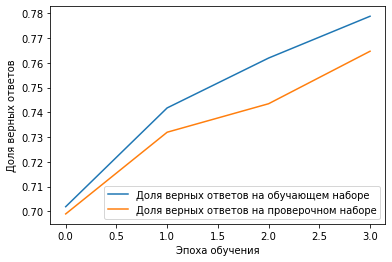

In [155]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='Доля верных ответов на обучающем наборе')
plt.plot(f1_val, label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [156]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7474064492148872

In [157]:
model.load_weights('model.hdf5')
# Размораживаем веса
model.layers[1].trainable = True

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall']) 
 

history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)   

Epoch 1/4
1276/1276 [==============================] - 138s 108ms/step - loss: 0.4300 - precision: 0.7951 - recall: 0.7964 - val_loss: 0.4950 - val_precision: 0.7506 - val_recall: 0.7578
Epoch 2/4
1276/1276 [==============================] - 133s 104ms/step - loss: 0.4071 - precision: 0.8096 - recall: 0.8105 - val_loss: 0.5071 - val_precision: 0.7595 - val_recall: 0.7352
Epoch 3/4
1276/1276 [==============================] - 132s 103ms/step - loss: 0.3829 - precision: 0.8251 - recall: 0.8254 - val_loss: 0.5139 - val_precision: 0.7387 - val_recall: 0.7707
Epoch 4/4
1276/1276 [==============================] - 137s 107ms/step - loss: 0.3593 - precision: 0.8380 - recall: 0.8373 - val_loss: 0.5319 - val_precision: 0.7756 - val_recall: 0.6912


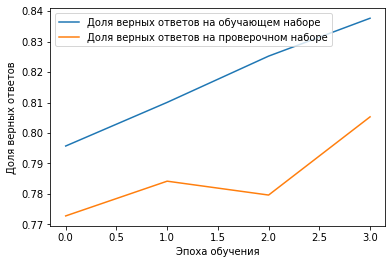

In [158]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='Доля верных ответов на обучающем наборе')
plt.plot(f1_val, label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [159]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7396568810253914

In [161]:
model = Sequential()
model.add(Embedding(len(embedding_matrix), len(embedding_matrix[0]),
          weights=[embedding_matrix], input_length=max_twit_len, trainable=False))
model.add(Conv1D(350, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/4
1276/1276 [==============================] - 92s 72ms/step - loss: 0.5736 - precision: 0.6917 - recall: 0.6771 - val_loss: 0.5382 - val_precision: 0.7097 - val_recall: 0.7379
Epoch 2/4
1276/1276 [==============================] - 88s 69ms/step - loss: 0.5304 - precision: 0.7234 - recall: 0.7283 - val_loss: 0.5282 - val_precision: 0.6989 - val_recall: 0.7851
Epoch 3/4
1276/1276 [==============================] - 92s 72ms/step - loss: 0.5075 - precision: 0.7403 - recall: 0.7460 - val_loss: 0.5119 - val_precision: 0.7288 - val_recall: 0.7471
Epoch 4/4
1276/1276 [==============================] - 89s 70ms/step - loss: 0.4878 - precision: 0.7525 - recall: 0.7621 - val_loss: 0.5142 - val_precision: 0.7612 - val_recall: 0.6800


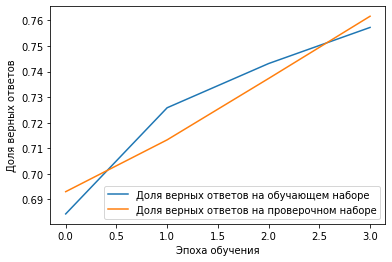

In [162]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='Доля верных ответов на обучающем наборе')
plt.plot(f1_val, label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [163]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.72748551689866

# Число слов в твитте

Вспомним как выглядит распеделение количества слов в твиттах

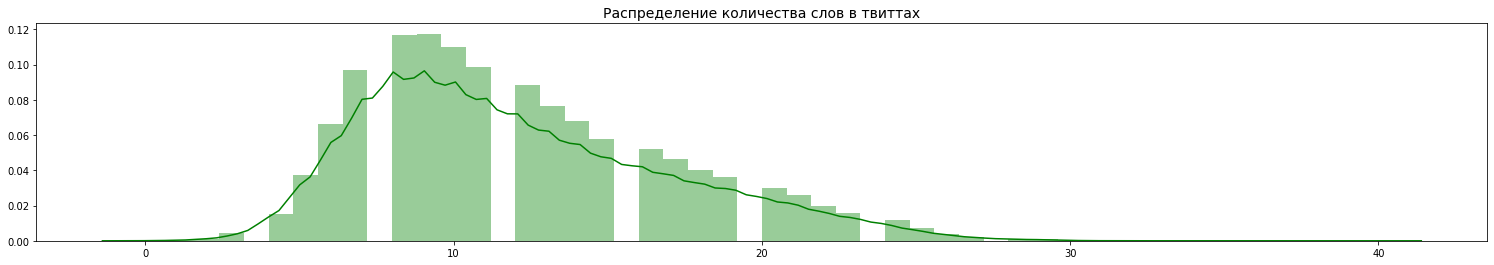

Попробуем протестировать разные значения, от 8 до 30, нечетные пока проверять не будем, чтобы не слишком долго считалось

In [36]:
from tensorflow.keras.layers import SpatialDropout1D
from sklearn.metrics import f1_score
for i in range(4,16):
  twit_len=i*2
  x_train = pad_sequences(sequences, twit_len)
  x_test = pad_sequences(test_sequences, twit_len)

  model = Sequential()
  model.add(Embedding(NUM, 64, input_length=twit_len))
  model.add(SpatialDropout1D(0.5))
  model.add(LSTM(128))
  #model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

  history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     
  print("\n","Результаты на длине = ",twit_len)

  pred=model.predict(x_test)
  result=np.zeros(y_test.size)
  for i in range(y_test.size):
    if (float(pred[i]) > 0.5):
      result[i]=1
    else:
      result[i]=0
  print(f1_score(y_test, result, average='macro'))

Epoch 1/3
1276/1276 [==============================] - 70s 55ms/step - loss: 0.5271 - precision: 0.7395 - recall: 0.7149 - val_loss: 0.5010 - val_precision: 0.7650 - val_recall: 0.7176
Epoch 2/3
1276/1276 [==============================] - 69s 54ms/step - loss: 0.4579 - precision: 0.7913 - recall: 0.7625 - val_loss: 0.4945 - val_precision: 0.7630 - val_recall: 0.7484
Epoch 3/3
1276/1276 [==============================] - 72s 57ms/step - loss: 0.4205 - precision: 0.8115 - recall: 0.7878 - val_loss: 0.5091 - val_precision: 0.7688 - val_recall: 0.7399

 Результаты на длине =  8
0.7523572944853665
Epoch 1/3
1276/1276 [==============================] - 84s 66ms/step - loss: 0.5152 - precision: 0.7419 - recall: 0.7348 - val_loss: 0.4906 - val_precision: 0.7742 - val_recall: 0.7267
Epoch 2/3
1276/1276 [==============================] - 81s 64ms/step - loss: 0.4459 - precision: 0.7959 - recall: 0.7742 - val_loss: 0.4848 - val_precision: 0.7761 - val_recall: 0.7334
Epoch 3/3
1276/1276 [========

при длине твитта в 20 достигается наилучший результат

Значения метрики после длины твиттов в 12 (среднее значение) становится довольно высоким, так что есть смысл проерить каждое непроверенное значение до 30 (нечетные)

In [38]:
from tensorflow.keras.layers import SpatialDropout1D
from sklearn.metrics import f1_score
for i in range(6,14):
  twit_len=i*2+1
  x_train = pad_sequences(sequences, twit_len)
  x_test = pad_sequences(test_sequences, twit_len)

  model = Sequential()
  model.add(Embedding(NUM, 64, input_length=twit_len))
  model.add(SpatialDropout1D(0.5))
  model.add(LSTM(128))
  #model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

  history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     
  print("\n","Результаты на длине = ",twit_len)

  pred=model.predict(x_test)
  result=np.zeros(y_test.size)
  for i in range(y_test.size):
    if (float(pred[i]) > 0.5):
      result[i]=1
    else:
      result[i]=0
  print(f1_score(y_test, result, average='macro'))

Epoch 1/3
1276/1276 [==============================] - 91s 71ms/step - loss: 0.5059 - precision: 0.7551 - recall: 0.7286 - val_loss: 0.4778 - val_precision: 0.7798 - val_recall: 0.7313
Epoch 2/3
1276/1276 [==============================] - 90s 71ms/step - loss: 0.4333 - precision: 0.8041 - recall: 0.7842 - val_loss: 0.4727 - val_precision: 0.7802 - val_recall: 0.7609
Epoch 3/3
1276/1276 [==============================] - 91s 71ms/step - loss: 0.3928 - precision: 0.8269 - recall: 0.8099 - val_loss: 0.4823 - val_precision: 0.7940 - val_recall: 0.7348

 Результаты на длине =  13
0.7711098370801339
Epoch 1/3
1276/1276 [==============================] - 100s 78ms/step - loss: 0.5045 - precision: 0.7556 - recall: 0.7311 - val_loss: 0.4761 - val_precision: 0.7640 - val_recall: 0.7696
Epoch 2/3
1276/1276 [==============================] - 98s 77ms/step - loss: 0.4298 - precision: 0.8049 - recall: 0.7877 - val_loss: 0.4663 - val_precision: 0.7919 - val_recall: 0.7436
Epoch 3/3
1276/1276 [======

По прежнему на 20 достигается лучшее значение, но возможно это вышло случайно, на длине 27 это значение лишь немногим хуже,  с точки зрения логики это значение будет более осмысленным, так как примерно 99% данных имеет длинну 27 твиттов или меньше, так что в конечном счете у твиттов будет 27 слов

# Число слов в словаре

Интуитивно кажется, что чем больше слов в словаре, тем лучше должна работать модель, но это не так. Ведь наличие слова в словаре не гарантирует то, что модель будет "понимать его значение". Если слово встречается слишком редко, то оно может находиться не на том месте в плотном векторном пространстве слов и из-за этого слова смысл отзыва может исказиться. Потому лучшим решением было бы просто не учитывать это слово. Найти то самое число слов в словаре с которого слова начинают встречаться слишком редко можно опытным путем.

In [24]:
from tensorflow.keras.layers import SpatialDropout1D
for i in range(1,10):
  num=i*10000
  # объявим токенизатор
  tokenizer = Tokenizer(num_words=num)
  # обучим токенизатор
  tokenizer.fit_on_texts(text_train)
  # токенизируем текст
  sequences = tokenizer.texts_to_sequences(text_train)
  # ограничим длинну отзывов
  x_train = pad_sequences(sequences, maxlen=max_twit_len) 
  test_sequences = tokenizer.texts_to_sequences(text_test)
  x_test = pad_sequences(test_sequences, maxlen=max_twit_len)

  model = Sequential()
  model.add(Embedding(num, 64, input_length=max_twit_len))
  model.add(SpatialDropout1D(0.5))
  model.add(LSTM(128))
  #model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

  history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     
  print("\n","Результаты на длинне = ",num)

  pred=model.predict(x_test)
  result=np.zeros(y_test.size)
  for i in range(y_test.size):
    if (float(pred[i]) > 0.5):
      result[i]=1
    else:
      result[i]=0
  print(f1_score(y_test, result, average='macro'))

Epoch 1/3
1276/1276 [==============================] - 24s 19ms/step - loss: 0.5063 - precision: 0.7519 - recall: 0.7350 - val_loss: 0.4679 - val_precision: 0.7717 - val_recall: 0.7655
Epoch 2/3
1276/1276 [==============================] - 23s 18ms/step - loss: 0.4489 - precision: 0.7886 - recall: 0.7809 - val_loss: 0.4602 - val_precision: 0.7837 - val_recall: 0.7549
Epoch 3/3
1276/1276 [==============================] - 23s 18ms/step - loss: 0.4255 - precision: 0.8031 - recall: 0.7946 - val_loss: 0.4585 - val_precision: 0.7762 - val_recall: 0.7873

 Результаты на длинне =  10000
0.7759328708369808
Epoch 1/3
1276/1276 [==============================] - 29s 23ms/step - loss: 0.5029 - precision: 0.7534 - recall: 0.7389 - val_loss: 0.4622 - val_precision: 0.7623 - val_recall: 0.7904
Epoch 2/3
1276/1276 [==============================] - 28s 22ms/step - loss: 0.4347 - precision: 0.7999 - recall: 0.7894 - val_loss: 0.4549 - val_precision: 0.7816 - val_recall: 0.7727
Epoch 3/3
1276/1276 [===

Можно заметить что на числе слов в словаре = 20 достигается наибольшее значение метрики. Это не обязательно луший вариант. Но в том чтобы найти прям какое-то точное значение, скорее всего смысла нет, потому что это в меру абстрактные значения и при минимальных изменениях в архитектуре все может резко поменяться.

# Регрессия LSTM

Ради интереса проверим какое значения метрики будет если всегда предсказывать только 0, это будет что-то вроде accuracy в 50% в бинарной классификации. Результат хуже которого быть не должно.

In [ ]:
from sklearn.metrics import mean_absolute_error
scores=np.zeros(y_test.size)
mean_absolute_error(scores,rtw_test)

3.2751620156064014

Далее попобуем предсказать количество ретвиттов. Для этого, нужно слегка изменить сеть.

В выходном слое нужно убрать функцию активации и вместо меток класса в обучение надо будет подавать количество твиттов.

В качестве loss фкнкции будем использовать седнеквадратичную ошибку

In [ ]:
from tensorflow.keras.layers import SpatialDropout1D
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae'])

history = model.fit(x_train, 
                    rtw_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)     

Epoch 1/4
1276/1276 [==============================] - 81s 64ms/step - loss: 10400.7871 - mae: 4.0826 - val_loss: 1341.8302 - val_mae: 3.7603
Epoch 2/4
1276/1276 [==============================] - 80s 63ms/step - loss: 10209.5479 - mae: 3.5930 - val_loss: 1220.9912 - val_mae: 3.2751
Epoch 3/4
1276/1276 [==============================] - 80s 62ms/step - loss: 10139.0195 - mae: 3.8568 - val_loss: 1194.3005 - val_mae: 3.7865
Epoch 4/4
1276/1276 [==============================] - 80s 63ms/step - loss: 10046.3623 - mae: 3.5197 - val_loss: 1107.0862 - val_mae: 3.3413


In [ ]:
model.evaluate(x_test, y_test, verbose=1)

1418/1418 [==============================] - 4s 3ms/step - loss: 98.8537 - mae: 2.0880


[98.85371398925781, 2.08803391456604]

Но в этой сети не учитывалось число подписчиков и прочие показатели, хотя они скорее всего должны влиять на число ретвиттов

Первое что мне пришло в голову, это взять создать модель состоящую только из одного эмбеддинга обученного для задачи регрессии ревтиттов, и при помощи него представить твитты в виде векторов, а затем эти значения передавать в какую-либо модель ML

In [ ]:
embedding_matrix = model.layers[0].get_weights()[0]
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.layers[0].get_weights()[0]=embedding_matrix

model.compile('rmsprop', 'mse')
twitt_vec_train=model.predict(x_train)
twitt_vec_test=model.predict(x_test)

data_train=np.hstack((data_train, twitt_vec_train.reshape(181468,1280)))
data_test=np.hstack((data_test, twitt_vec_test.reshape(45366,1280)))

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10)
rf.fit(data_train, rtw_train)

from sklearn.metrics import mean_absolute_error
scores = rf.predict(data_test)
mean_absolute_error(scores,rtw_test)

3.55213155226381

Когда я использовал рандомный лес начала быстро заканчиваться оперативная память, поэтому пришлос ограничить глубину дерева.

Метрика качества ухудшилась, а значит я сделал что-то не так

# Регрессия CNN

Для начала просто попробуем обучить сеть также как в случае с LSTM

In [61]:
text_train[0]

'как же хотеться он забыть ааа не мочь так большой'

In [62]:
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(Conv1D(350, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae'])

history = model.fit(x_train, 
                    rtw_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/4
1276/1276 [==============================] - 73s 57ms/step - loss: 11843.8389 - mae: 5.2890 - val_loss: 375.6114 - val_mae: 2.1907
Epoch 2/4
1276/1276 [==============================] - 72s 56ms/step - loss: 6598.4512 - mae: 3.8233 - val_loss: 1234.3724 - val_mae: 3.7863
Epoch 3/4
1276/1276 [==============================] - 70s 55ms/step - loss: 938.9763 - mae: 2.7545 - val_loss: 428.0359 - val_mae: 2.5265
Epoch 4/4
1276/1276 [==============================] - 73s 57ms/step - loss: 625.0852 - mae: 2.1928 - val_loss: 388.3253 - val_mae: 2.2431


In [63]:
model.evaluate(x_test, rtw_test, verbose=1)

1418/1418 [==============================] - 6s 4ms/step - loss: 897.6321 - mae: 2.5548


[897.632080078125, 2.5548019409179688]

In [ ]:
rtw_test[:100]

array([ 0,  0,  1,  0,  1,  3,  0,  0,  0,  1,  0,  0,  0,  0,  6,  0,  0,
        0,  0,  0,  0,  0, 93,  1,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 45,  0,  0,  1,  0,  1,  6,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  9,
        3,  0,  1,  0,  0,  0,  2,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,
        1, 42,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1])

In [ ]:
pred_test.astype(int).reshape(scores.shape)[:100]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 35,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 35,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
scores[:100]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Далее попробуем вместо того, чтобы передавать векторные представления твиттов, будем передавать прогноз количества ретвиттов, которые дала нейронная сеть

In [64]:
pred_train=model.predict(x_train)
pred_test=model.predict(x_test)
#добавим информацию о количестве подписок у пользователя, оставившего твитт
X_train=np.hstack((data_train[:,1].reshape(181468,1), pred_train))
X_test=np.hstack((data_test[:,1].reshape(45366,1), pred_test))

попробуем лог регресию

In [67]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, rtw_train)

from sklearn.metrics import mean_absolute_error
scores = lr.predict(X_test)
mean_absolute_error(scores,rtw_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3.1557333686020366

Регрессия ухудшила результат

Попробуем подавать число подписчиков и listcount

In [ ]:
pred_train=model.predict(x_train)
pred_test=model.predict(x_test)
#тоько число подписчиков и listcount
data_train=np.hstack((data_train[:,1:4:2], pred_train))
data_test=np.hstack((data_test[:,1:4:2], pred_test))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(data_train, rtw_train)

from sklearn.metrics import mean_absolute_error
scores = lr.predict(data_test)
mean_absolute_error(scores,rtw_test)

2.66009787065203

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150,max_depth=10)
rf.fit(data_train, rtw_train)

from sklearn.metrics import mean_absolute_error
scores = rf.predict(data_test)
mean_absolute_error(scores,rtw_test)

2.5452100692148303

In [ ]:
data_train.shape[0]

181468

Теперь попробуем обучить полносвязную нейронную сеть

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Создаем последовательную модель
model = Sequential()
model.add(Dense(1024,activation='relu', input_shape=(data_train.shape[1],) ))
model.add(Dropout(0.3, seed=None))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,  activation='relu'))

model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae'])

history = model.fit(data_train, 
                    rtw_train, 
                    epochs=15,
                    batch_size=128,
                    validation_split=0.2)     

Epoch 1/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8286.6992 - mae: 3.1488 - val_loss: 25117.0762 - val_mae: 6.1498
Epoch 2/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8192.6934 - mae: 3.2826 - val_loss: 26497.8906 - val_mae: 3.9918
Epoch 3/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8340.0400 - mae: 3.2873 - val_loss: 25950.4727 - val_mae: 4.1084
Epoch 4/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8398.7930 - mae: 3.2921 - val_loss: 25993.3242 - val_mae: 4.1617
Epoch 5/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8293.0674 - mae: 3.1949 - val_loss: 25030.2402 - val_mae: 5.4785
Epoch 6/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8347.4248 - mae: 3.2491 - val_loss: 25795.9062 - val_mae: 4.0423
Epoch 7/15
1135/1135 [==============================] - 3s 3ms/step - loss: 8312.5195 - mae: 3.2766 - val_loss: 25627.7461 - val_mae: 4.2089
Epoch 8/15
11

In [ ]:
model.evaluate(data_test, rtw_test, verbose=1)

1418/1418 [==============================] - 2s 2ms/step - loss: 4664.0107 - mae: 2.4298


[4664.0107421875, 2.4297845363616943]

# "ахахахахха"

возникла гипотеза, что если привести различные формы "ахахаха" к единой, то это может улучшить метрику

* Все слова начинающиеся с ахахахаха будут присведены к формату "ахах"
* А слова начинающиеся с "хахахахах" приводятся к фомату "хах"

In [47]:
def preprocess_text(text):
    re.sub('(хах?[^\s]+)', 'хах', text)
    return text.strip()
df["preprocess_text2"] = [preprocess_text(t) for t in df.preprocess_text]

In [48]:
x = df.drop(['type','id','date','name','trtw','trep','tfav','text'], axis=1)
y = df['type']

# возвращает train и test сохраняя при этом баланс классов
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# skf.split генерирует индексы
for train_index, test_index in skf.split(x, y):
    data_train, data_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# Преобразуем в массив
text_train = data_train['preprocess_text'].values
text_test = data_test['preprocess_text'].values
text_train2 = data_train['preprocess_text2'].values
text_test2 = data_test['preprocess_text2'].values
y_train = y_train.values
y_test = y_test.values

# Убедимся в том, что балланс классов не изменился
a,b=np.unique(y_train, return_counts=True)
c,d=np.unique(y_test, return_counts=True)
print('Label Distributions: \n')
print(b/ len(y_train))
print(d/ len(y_test))

Label Distributions: 

[0.49341482 0.50658518]
[0.49340916 0.50659084]


In [68]:
# объявим токенизатор
tokenizer = Tokenizer(num_words=NUM)
# обучим токенизатор
tokenizer.fit_on_texts(text_train)
# токенизируем текст
sequences = tokenizer.texts_to_sequences(text_train)
# ограничим длинну отзывов
x_train = pad_sequences(sequences, maxlen=max_twit_len)

test_sequences = tokenizer.texts_to_sequences(text_test)
x_test = pad_sequences(test_sequences, maxlen=max_twit_len)


In [50]:
from tensorflow.keras.layers import SpatialDropout1D
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     

Epoch 1/3
1276/1276 [==============================] - 43s 34ms/step - loss: 0.5032 - precision: 0.7547 - recall: 0.7424 - val_loss: 0.4612 - val_precision: 0.7663 - val_recall: 0.7945
Epoch 2/3
1276/1276 [==============================] - 42s 33ms/step - loss: 0.4223 - precision: 0.8095 - recall: 0.7951 - val_loss: 0.4560 - val_precision: 0.7576 - val_recall: 0.8198
Epoch 3/3
1276/1276 [==============================] - 43s 33ms/step - loss: 0.3821 - precision: 0.8335 - recall: 0.8187 - val_loss: 0.4669 - val_precision: 0.7775 - val_recall: 0.7872


In [51]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7775709680405383

In [69]:
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(Conv1D(350, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=2,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/2
1276/1276 [==============================] - 39s 31ms/step - loss: 0.4854 - precision: 0.7550 - recall: 0.7640 - val_loss: 0.4462 - val_precision: 0.7747 - val_recall: 0.8134
Epoch 2/2
1276/1276 [==============================] - 38s 30ms/step - loss: 0.3595 - precision: 0.8443 - recall: 0.8376 - val_loss: 0.4559 - val_precision: 0.8231 - val_recall: 0.7240


In [70]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7796584373537958

In [54]:
# объявим токенизатор
tokenizer = Tokenizer(num_words=NUM)
# обучим токенизатор
tokenizer.fit_on_texts(text_train2)
# токенизируем текст
sequences = tokenizer.texts_to_sequences(text_train2)
# ограничим длинну отзывов
x_train = pad_sequences(sequences, maxlen=max_twit_len)

test_sequences = tokenizer.texts_to_sequences(text_test2)
x_test = pad_sequences(test_sequences, maxlen=max_twit_len)


In [55]:
from tensorflow.keras.layers import SpatialDropout1D
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=3,
                    batch_size=128,
                    validation_split=0.1)     

Epoch 1/3
1276/1276 [==============================] - 42s 33ms/step - loss: 0.5037 - precision: 0.7511 - recall: 0.7460 - val_loss: 0.4598 - val_precision: 0.7781 - val_recall: 0.7741
Epoch 2/3
1276/1276 [==============================] - 41s 32ms/step - loss: 0.4236 - precision: 0.8081 - recall: 0.7953 - val_loss: 0.4534 - val_precision: 0.7893 - val_recall: 0.7610
Epoch 3/3
1276/1276 [==============================] - 42s 33ms/step - loss: 0.3848 - precision: 0.8310 - recall: 0.8201 - val_loss: 0.4594 - val_precision: 0.7767 - val_recall: 0.7828


In [56]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7785509362640846

In [65]:
model = Sequential()
model.add(Embedding(NUM, 64, input_length=max_twit_len))
model.add(Conv1D(350, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['Precision', 'Recall'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=2,
                    batch_size=128,
                    validation_split=0.1)  

Epoch 1/2
1276/1276 [==============================] - 36s 29ms/step - loss: 0.4865 - precision: 0.7539 - recall: 0.7647 - val_loss: 0.4456 - val_precision: 0.7921 - val_recall: 0.7735
Epoch 2/2
1276/1276 [==============================] - 36s 28ms/step - loss: 0.3586 - precision: 0.8449 - recall: 0.8366 - val_loss: 0.4464 - val_precision: 0.7856 - val_recall: 0.7844


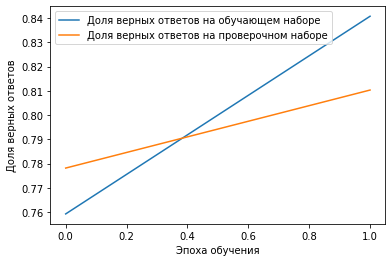

In [66]:
f1=2*(np.array(history.history['precision'])*np.array(history.history['recall']))/(np.array(history.history['precision'])+np.array(history.history['recall']))
f1_val=2*(np.array(history.history['val_precision'])*np.array(history.history['recall']))/(np.array(history.history['val_precision'])+np.array(history.history['recall']))

plt.plot(f1, label='Доля верных ответов на обучающем наборе')
plt.plot(f1_val, label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import f1_score
pred=model.predict(x_test)
result=np.zeros(y_test.size)
for i in range(y_test.size):
  if (float(pred[i]) > 0.5):
    result[i]=1
  else:
    result[i]=0
f1_score(y_test, result, average='macro')

0.7826315556076449

Похоже на то, что гипотеза веррная